In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import IPython.display
from utils import *

# Wczytywanie odcisku palca

In [2]:
fingerprint = cv.imread('Database/all/2_2.tif', cv.IMREAD_GRAYSCALE)

odcisk
""

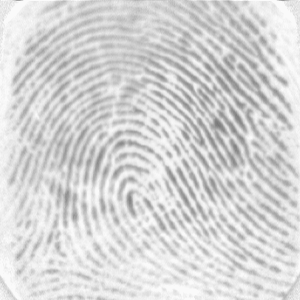

In [3]:
show(fingerprint,'odcisk')

# Używanie filtru Sobel'a do uwypuklenia krawędzi

In [4]:
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

,
,

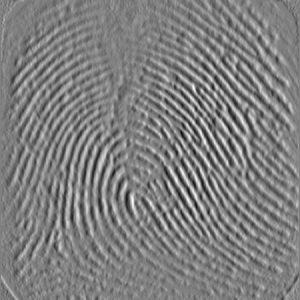
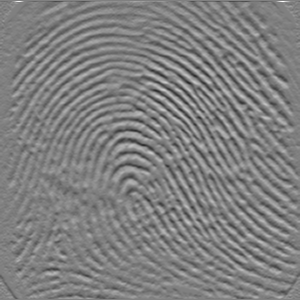

In [5]:
show(gx, gy)

In [6]:
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)

""
""

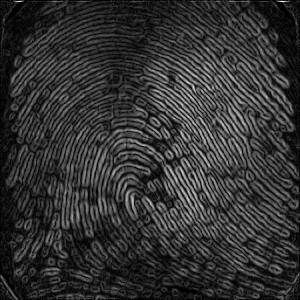

In [7]:
show(gm)

# Tworzenie maski

In [8]:
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

,,
,,

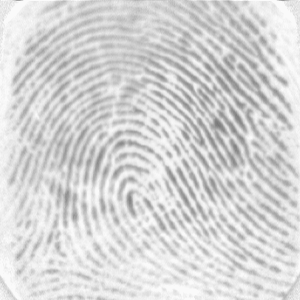
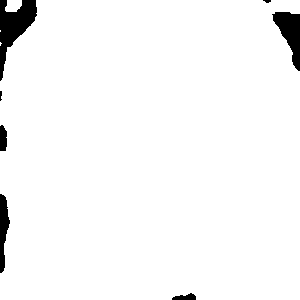
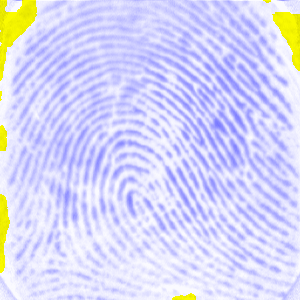

In [9]:
show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

# Znajdywanie mapy orientacji

In [10]:
W = (23, 23)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

In [11]:
orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
sum_gxx_gyy = gxx + gyy
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)

Orientation image
""

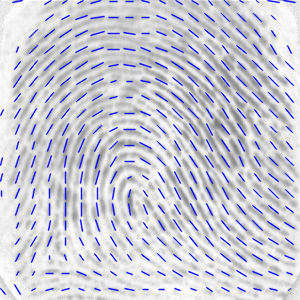

In [12]:
show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

# Szukanie cech pierwszego poziomu na podstawie mapy orientacji

In [13]:
singular_points = calculate_poincare_index(orientations, mask, step=10, window_size=6)

In [14]:
singular_points = merge_nearby_points(singular_points, distance_threshold=50)

In [23]:
result_image = draw_orientations(fingerprint, orientations, strengths, mask, 1, 16)
for sp in singular_points:
    x, y = sp['coords']
    scaled_x, scaled_y = x, y
    color = (0, 255, 255) if sp['type'] == 'core' else (0, 255, 0)
    cv.circle(result_image, (scaled_x, scaled_y), 30, color, 2)
    # cv.putText(result_image, sp['type'], (scaled_x + 50, scaled_y), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

""
""

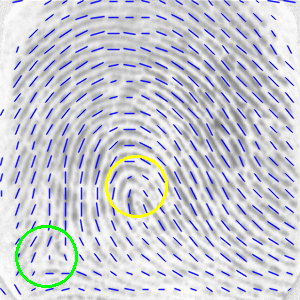

In [24]:
show(result_image)

In [17]:
fingerprint_class = classify_fingerprint(singular_points)

In [18]:
print(f"\nKlasa odcisku palca: {fingerprint_class}")


Klasa odcisku palca: Pętla Prawa (Right Loop)


# Wyszukiwanie odcisków w bazie danych